# Swept Langmuir Analysis: Ion-Saturation Current

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pprint

from pathlib import Path

from plasmapy.analysis import swept_langmuir as sla

plt.rcParams['figure.figsize'] = [10.5, 0.56 * 10.5]

## Contents:

1. [How does **find_floating_potential()** work?](#How-does-find_floating_potential()-work?)
    1. [Notes about usage](#Notes-about-usage)
    1. [Knobs to turn](#Knobs-to-turn)
1. [Calculate the Floating Potential](#Calculate-the-Floating-Potential)
    1. [Interpreting results](#Interpreting-results)
    1. [Plotting results](#Plotting-results)

## How does `find_floating_potential()` work?

1. The passed current array is scanned for points that equal zero and point-pairs that straddle $I = 0$.  This forms an collection of "crossing-points."
1. The crossing-points are then grouped into "crossing-islands" based on the `threshold` keyword.
    - A new island is formed when a successive crossing-point is more (index) steps away from the previous corssing-point than defined by `threshold`.  For example, if `threshld=4` then an new island is formed if a crossing-point candidate is more than 4 steps away from the previous candidate.
    - If multiple crossing-islands are identified, then the function will compare the total span of all crossing-islands to `min_points`.  If the span is greater than `min_points`, then the function is incapable of identifying $V_f$ and will return `numpy.nan` values; otherwise, the span will form one larger crossing-island.
1. To calculate the floating potential...
    - If the number of points that make up the crossing-island is less than `min_points`, then each side of the "crossing-island" is equally padded with the nearest neighbor points until `min_points` is satisfied.
    - If `fit_type="linear"`, then a `scipy.stats.linregress` fit is applied to the points that make up the crossing-island.
    - If `fit_type="exponential"`, then a `scipy.optimize.curve_fit` fit is applied to the points that make up the crossing-island.

### Notes about usage

- The function provides no signal processing, so, if needed, the user must smooth, sort, crop, etc. the arrays before passing to the function.
- The function requires the voltage array to be monotonically increasing or decreasing.
- If the total range spanned by all crossing-islands is less than or equal to `min_points`, then `threshold` is ignored and all crossing-islands are grouped into one island.

### Knobs to turn

- `fit_type`

    There are two types of curves that can be fitted to the identified crossing point data, `"linear"` and `"exponential"`.  The former will fit fit a line to the data, whereas, the later will fit and exponential curve with an offset.  The default curve is `"exponential"` since swept Langmuir data is not typically linear as it passes through $I=0$.

- `min_points`

    This specifies the minimum number of points that will be used in the curve fitting.  As mentioned above,  the crossing-islands are identified and then padded until `min_points` is satisfied.
    
    - `min_pints = None` (Default) then the larger of 5 and `factor * array_size` is taken, where `factor = 0.1` for `"linear"` and `0.2` for `"exponential"`.
    - `min_points = 0` then the entire passed array is fitted.
    - `min_points >= 1` then this is the minimum number of points used.
    - `0 < min_points < 1` then then the minimum number of points is taken as `min_points * array_size`.


- `threshold`

    The max allowed index distance between crossing-points before a new crossing-island is formed.

## Calculate the Floating Potential

Below we'll compute the floaing potential using the default fitting behavior (`fit_type="exponential"`) and a linear fit (`fit_type="linear"`).

In [7]:
# load data
filename = "Beckers2017_noisy.npy"
filepath = (Path.cwd() / ".." / ".." / "langmuir_samples" / filename).resolve()
voltage, current = np.load(filepath)

# voltage array needs to be monotonically increasing/decreasing
isort = np.argsort(voltage)
voltage = voltage[isort]
current = current[isort]

# get default fit results (exponential fit)
# results = sla.find_floating_potential(voltage, current, min_points=0.3)
results_opt = sla.find_ion_saturation_current(voltage, current, fit_type="linear", upper_bound=-10)

# get linear fit results
# results_lin = sla.find_floating_potential(voltage, current, fit_type="linear")
results = sla.find_ion_saturation_current(voltage, current)
(results,
 results.isat_func.parameters,
 results.func.parameters,
 "-- break --",
 results_opt,
 results_opt.isat_func.parameters,
 results_opt.func.parameters,
)

(FloatingPotentialResults(isat_func=f(x) = m x + b <class 'plasmapy.analysis.swept_langmuir.fit_functions.LinearFitFunction'>, rsq=0.9681862861882226, func=f(x) = A exp(alpha x) + m x + b <class 'plasmapy.analysis.swept_langmuir.fit_functions.ExponentialLinearFitFunction'>, indices=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127

### Interpreting results

The `find_floating_potential()` returns a six element named tuple, where...

- `results[0]` = `results.vf` = the determined floating potential (in volts)


In [3]:
# (results[0], results.vf)

- `results[1]` = `results.vf_err` = the associated error (in volts)

In [4]:
# (results[1], results.vf_err)

- `results[2]` = `results.rsq` = the coeficient of determination (r-squared) value of the fit

In [5]:
# (results[2], results.rsq)

- `results[3]` = `results.func` = the resulting fitted function

    - `results.func` is a callable representation of the fitted function `I = results.func(V)`.
    - `resulst.func` is an instance of a sub-class of `AbstractFitFunction`. ([**FitFuction** classes](../../../api_static/plasmapy.analysis.swept_langmuir.fit_functions.rst))
    - Since `results.func` is a class instance, there are many other attribures available.  For example,
        - `results.func.parameters` is a named tuple of the fitted parameters
        - `results.func.parameters_err` is a named tuple of the fitted parameter errors
        - `results.func.root_solve()` finds the roots of the fitted function. This is how $V_f$ is calculated.

In [6]:
# (results[3],
#  results.func,
#  results.func.parameters,
#  results.func.parameters.a,
#  results.func.parameters_err,
#  results.func.parameters_err.a,
#  results.func(results.vf),
# )

- `results[4]` = `results.islands` = a list of slice objects representing all the indentified crossing-islands

In [7]:
# (results[4], 
#  results.islands,
#  voltage[results.islands[0]],
# )

- `results[5]` = `results.indices` = a slice object representing the indices used in the fit

In [8]:
# (results[5],
#  results.indices,
#  voltage[results.indices],
# )

### Plotting results

In [9]:
results.isat_func(5, reterr=True)

(-0.001837668067056153, 0.0011231311264985006)

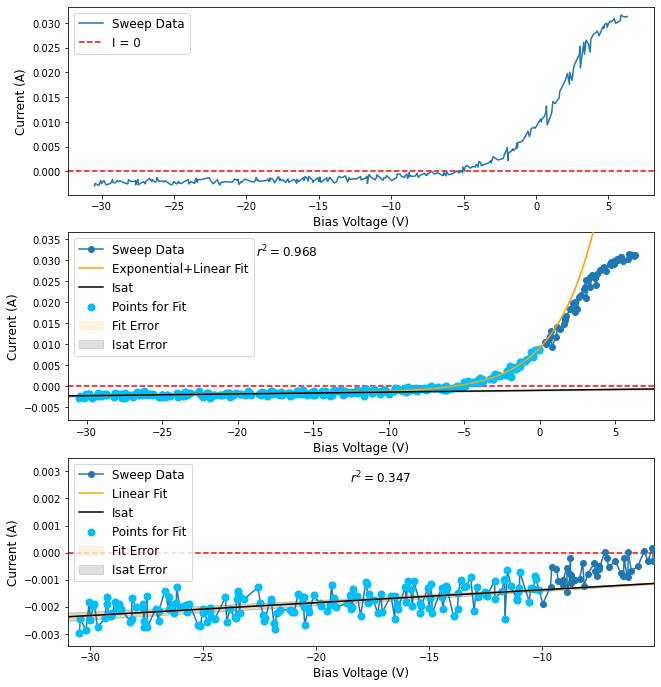

In [25]:
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 2. * figheight
fig, axs = plt.subplots(3, 1, figsize=[figwidth, figheight])

# plot original data
axs[0].set_xlabel("Bias Voltage (V)", fontsize=12)
axs[0].set_ylabel("Current (A)", fontsize=12)

axs[0].plot(voltage, current, zorder=10, label="Sweep Data")
axs[0].axhline(0.0, color='r', linestyle='--', label="I = 0")
axs[0].legend(fontsize=12)

# zoom on fit
for ii, label, fit in zip([1, 2], ["Exponential+Linear", "Linear"], [results, results_opt]):
    # calc island points
#     isl_pts = np.array([], dtype=np.int64)
#     for isl in fit.islands:
#         isl_pts = np.concatenate((isl_pts, np.r_[isl]))
    
    # calc xrange for plot
    xlim = [voltage[fit.indices].min(),
            voltage[fit.indices].max()]
    vpad = 0.25 * (xlim[1] - xlim[0])
    xlim = [xlim[0] - 0.1 * vpad,
            xlim[1] + vpad]
    
    # calc yrange for plot
    umask = np.where(voltage >= xlim[0], True, False)
    lmask = np.where(voltage <= xlim[1], True, False)
    mask = np.logical_and(umask, lmask)
    ylim = [current[mask].min(), current[mask].max()]
    ypad = 0.15 * (ylim[1] - ylim[0])
    factor = 7 if label == "Linear" else 1
    ylim = [ylim[0] - ypad, ylim[1] + factor * ypad]

    # calc data points for fit curve
    vfit = np.linspace(xlim[0], xlim[1], 201, endpoint=True)
    ifit, ifit_err = fit.func(vfit, reterr=True)
    
    # calc isat line
    isat, isat_err = fit.isat_func(vfit, reterr=True)

    axs[ii].set_xlabel("Bias Voltage (V)", fontsize=12)
    axs[ii].set_ylabel("Current (A)", fontsize=12)
    axs[ii].set_xlim(xlim)
    axs[ii].set_ylim(ylim)

    zorder = 10
    axs[ii].plot(voltage[mask], current[mask],
                 marker="o", 
                 zorder=zorder, 
                 label="Sweep Data")
    zorder += 1
    axs[ii].scatter(voltage[fit.indices],
                    current[fit.indices],
                    linewidth=2, s=6**2, 
                    facecolors="deepskyblue", edgecolors="deepskyblue",
                    zorder=zorder,
                    label="Points for Fit")
#     axs[ii].scatter(voltage[isl_pts], current[isl_pts],
#                     linewidth=2, s=8**2, 
#                     facecolors="deepskyblue", edgecolors="black",
#                     zorder=12,
#                     label="Island Points")
    axs[ii].autoscale(False)
    zorder += 1
    axs[ii].plot(vfit, ifit, color="orange",
                 zorder=zorder,
                 label=label + " Fit")
    axs[ii].fill_between(vfit, ifit + ifit_err, ifit - ifit_err,
                         color="orange", alpha=0.12, zorder=0,
                        label="Fit Error")
    axs[ii].axhline(0.0, color='r', linestyle='--')
    zorder += 1
    axs[ii].plot(vfit, isat, color="black",
             label="Isat", zorder=zorder)
    axs[ii].fill_between(vfit, isat + isat_err, isat - isat_err,
                         color="black", alpha=0.12, zorder=0,
                        label="Isat Error")
#     axs[ii].fill_between([fit.vf - fit.vf_err, fit.vf + fit.vf_err], 
#                         axs[1].get_ylim()[0],
#                         axs[1].get_ylim()[1],
#                         color='grey', alpha=0.1)
    axs[ii].legend(fontsize=12)

    # add text
    rsq = fit.rsq
    txt = f"$r^2 = {rsq:.3f}$"
#     txt = (f"$V_f = {fit.vf:.2f} \\pm {fit.vf_err:.2f}$ V\n"
#            f"$r^2 = {rsq:.3f}$")
    txt_loc = [-18, axs[ii].get_ylim()[1]]
    txt_loc = axs[ii].transAxes.inverted().transform(axs[ii].transData.transform(txt_loc))
    txt_loc[0] -= 0.02
    txt_loc[1] -= 0.13
    axs[ii].text(txt_loc[0], txt_loc[1], txt, 
                 fontsize='large', transform=axs[ii].transAxes,
                 ha="left")

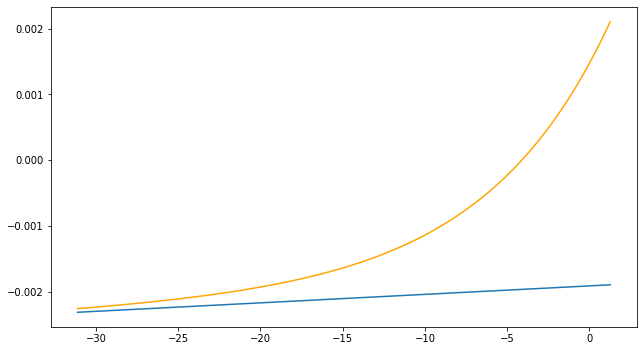

In [4]:
plt.plot(vfit, isat)
plt.plot(vfit, ifit, color="orange")